In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import skimage
from tqdm import tqdm
import keras
from keras.datasets import mnist, cifar10, fashion_mnist

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

In [3]:
X_train.shape

(60000, 28, 28)

In [4]:
def cv2_rotate(image, degrees):
    if len(image.shape) == 3:
        rows, cols, _ = image.shape
    else:
        rows, cols = image.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2), degrees, 1)
    return cv2.warpAffine(image, M, (cols,rows))

In [5]:
def pad(image, padding=2):
    
    h, w = image.shape
    image_padded = np.zeros((h + 2*padding, w + 2*padding))
    image_padded[padding:-padding, padding:-padding] = image
    return image_padded

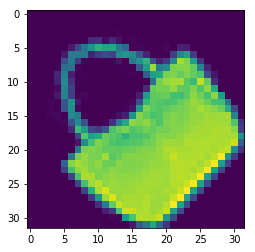

In [6]:
plt.imshow(cv2_rotate(pad(X_train[100]), 45))

In [7]:
augmented_rotations_per_sample = 3

In [8]:
def generate_random_rotations(X, Y, n_rotations_per_sample, rot_range=10):
    
    new_X = []
    new_Y = []
    rotations = []
    
    h, w = X.shape[1:]
    bigger = 2
    
    for image, label in tqdm(zip(X, Y), total=len(X)):
        
        image = pad(image)
        
        for _ in range(n_rotations_per_sample):
            
            rotation = np.random.randint(-rot_range, rot_range)
            rotated_image = cv2_rotate(image, rotation)
            new_X.append(rotated_image)
            new_Y.append(label)
            rotations.append(rotation)
    
    new_X = np.array(new_X)
    if len(new_X.shape) == 3:
        new_X = np.expand_dims(new_X, 3)
        
    return new_X, np.array(new_Y), np.array(rotations)

In [9]:
X_train_rot, Y_train_rot, R_train = generate_random_rotations(X_train, Y_train, augmented_rotations_per_sample)
X_test_rot, Y_test_rot, R_test = generate_random_rotations(X_test, Y_test, augmented_rotations_per_sample)

Y_train_onehot = keras.utils.to_categorical(Y_train_rot)
Y_test_onehot = keras.utils.to_categorical(Y_test_rot)

100%|██████████| 10000/10000 [00:00<00:00, 13673.59it/s]


In [10]:
nb_classes = Y_train_onehot.shape[1]

In [11]:
from keras import layers
from keras import models
from keras import losses
import keras.backend as K

input_layer = layers.Input(X_train_rot.shape[1:], name='image_input')
x = input_layer

x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.25)(x)
x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.25)(x)
x = layers.Flatten()(x)
encoder_layer = layers.Dense(128, activation='relu')(x)

x = layers.Reshape((8, 8, -1))(encoder_layer)
x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
x = layers.UpSampling2D()(x)
x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
x = layers.UpSampling2D()(x)
autoencoder_layer = layers.Conv2D(1, (3,3), padding='same', activation='relu')(x)

model = models.Model(input_layer, autoencoder_layer)        
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 32)        9248      
__________

In [12]:
from keras import callbacks

class LossWeightsCallback(callbacks.Callback):
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta
        
    # customize your behavior
    def on_epoch_end(self, epoch, logs={}):
        if epoch == 1:
            self.alpha = self.alpha - 0.4 # set to 0.5
            self.beta = self.beta + 0.4 # set to 0.5

In [13]:
def train_model(model):
        
    
    early_stopper = callbacks.EarlyStopping(patience=1)

    _callbacks = [early_stopper]
    
    return model.fit(X_train_rot, X_train_rot, 
                     validation_data=(X_test_rot, X_test_rot), 
                     callbacks=_callbacks,
                     batch_size=256,
                     epochs=10)

In [14]:
rot_range = 180
    
print('Training on rotation range of +-', rot_range)

X_train_rot, Y_train_rot, R_train = generate_random_rotations(X_train, Y_train, 
                                                              augmented_rotations_per_sample, rot_range)
X_test_rot, Y_test_rot, R_test = generate_random_rotations(X_test, Y_test, 
                                                           augmented_rotations_per_sample, rot_range)

X_train_rot /= 255.
X_test_rot /= 255.

history = train_model(model).history

Y_pred, R_pred = model.predict(X_test_rot)
diff_degree = np.abs(np.arctan2(R_pred[:, 0], R_pred[:, 1]) * 180 / np.pi - R_test)
diff_degree = np.array([diff if diff < 180 else 360 - diff for diff in diff_degree])
print(np.mean(diff_degree))


  2%|▏         | 1302/60000 [00:00<00:04, 13010.71it/s]

Training on rotation range of +- 180


100%|██████████| 10000/10000 [00:00<00:00, 13630.40it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 51s 283us/step - loss: 0.0150 - acc: 0.5417 - val_loss: 0.0096 - val_acc: 0.5410
Epoch 2/10
116480/180000 [==================>...........] - ETA: 16s - loss: 0.0084 - acc: 0.5423 ETA: 17s 

KeyboardInterrupt: 

In [46]:
from im_utils import plotgrid

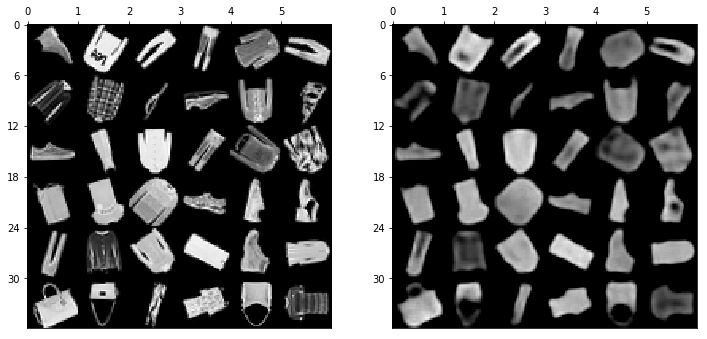

In [55]:
plt.figure(figsize=(12, 10))
plt.subplot(121)
plotgrid(X_test_rot[:108:3], show=False)
plt.subplot(122)
plotgrid(model.predict(X_test_rot[:108:3]))

In [16]:
encoder = models.Model(input_layer, encoder_layer)

In [17]:
encoded_train = encoder.predict(X_train_rot)

In [18]:
from sklearn.neighbors import NearestNeighbors

In [19]:
space = NearestNeighbors(n_neighbors=1)
space.fit(encoded_train)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=1, p=2, radius=1.0)

In [20]:
encoded_test = encoder.predict(X_test_rot)

In [26]:
from tqdm import tqdm

R_pred = []
Y_pred = []

for encoded_test_vector in tqdm(encoded_test):
    distance, idx = space.kneighbors(encoded_test_vector.reshape((1, -1)))
    R_pred.append(R_train[idx])
    Y_pred.append(Y_train_rot[idx])
    
R_pred = np.array(R_pred)
Y_pred = np.array(Y_pred)

100%|██████████| 30000/30000 [06:42<00:00, 74.61it/s]


In [32]:
R_pred = R_pred.squeeze()
Y_pred = Y_pred.squeeze()

In [40]:
np.count_nonzero(Y_pred == Y_test_rot) / len(Y_pred)

0.7688

In [41]:
diff_degree = np.abs(R_pred - R_test)
diff_degree = np.array([diff if diff < 180 else 360 - diff for diff in diff_degree])

In [42]:
np.mean(diff_degree)

8.970966666666667

In [ ]:
distance, idx = space.query(encoder.predict(X_test_rot[100:101])[0])

In [ ]:
print([history['val_r_loss'][-1] for history in histories])
print([history['val_y_acc'][-1] for history in histories])
print(np.mean(diff_degrees, axis=1))
print(np.std(diff_degrees, axis=1))

In [ ]:
print([history['val_r_loss'][-1] for history in histories])
print([history['val_y_acc'][-1] for history in histories])
print(np.mean(diff_degrees, axis=1))
print(np.std(diff_degrees, axis=1))

In [ ]:
R_test_sin_cos[:10]

In [ ]:
def get_data_from_histories():

    for history in histories:

        idx_min_loss = np.argmin(history['val_loss'])
        data = []

        for key in ('val_loss', 'val_r_loss', 'val_r_acc', 'val_y_loss', 'val_y_acc'):
            data.append(history[key][idx_min_loss])
            
        yield data

In [ ]:
data = np.array(list(get_data_from_histories()))

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt

In [ ]:
plt.figure(figsize=(12, 10))
plt.subplot(211)
plt.grid()
plt.plot(np.arange(10, 190, 10) * 2, data[:, 4], label='classification_accuracy')
plt.xlabel('Rotation range (degrees)')
plt.legend()
plt.subplot(212)
plt.grid()
plt.plot(np.arange(10, 190, 10) * 2, data[:, 1], label='rotation_loss')
plt.xlabel('Rotation range (degrees)')
plt.legend()

In [ ]:
np.mean(diff_degrees, axis=1)

In [ ]:
Y_pred, R_pred = model.predict(X_test_rot)

In [ ]:
diff_degree = np.abs(np.arctan2(R_pred[:, 0], R_pred[:, 1]) * 180 / np.pi - R_test)
diff_degree = np.array([diff if diff < 180 else 360 - diff for diff in diff_degree])
print(np.mean(diff_degree))

In [ ]:
Y_pred[:20]

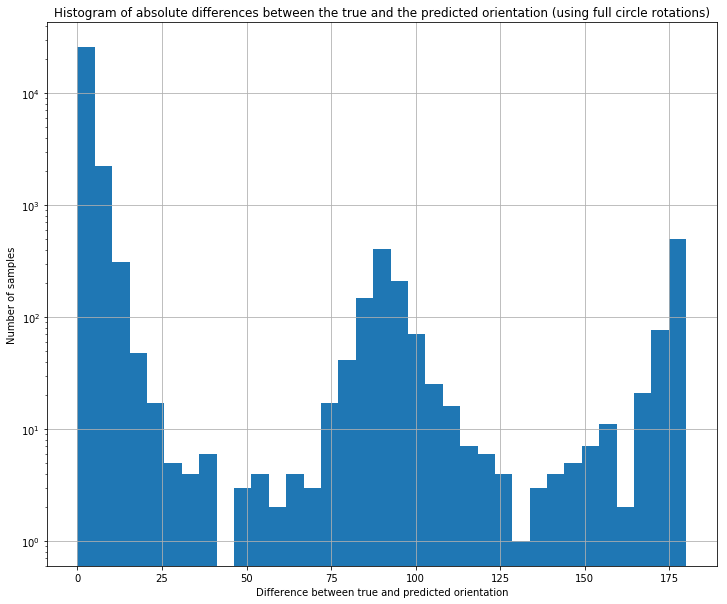

In [44]:
plt.figure(figsize=(12, 10))
plt.title('Histogram of absolute differences between the true and the predicted orientation (using full circle rotations)')
plt.hist(diff_degree, bins=35)
plt.grid()
plt.xlabel('Difference between true and predicted orientation')
plt.ylabel('Number of samples')
plt.yscale('log')
plt.show()

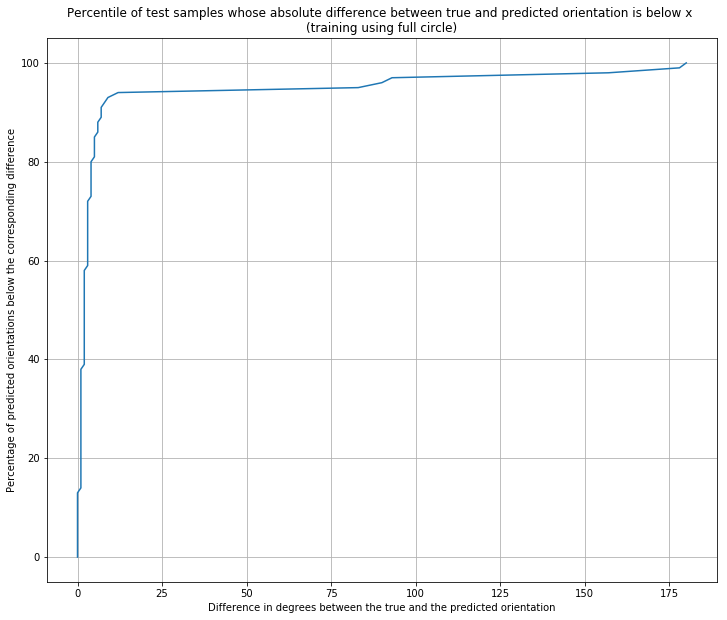

In [45]:
xv = np.arange(0, 101)
plt.figure(figsize=(12, 10))
plt.grid()
plt.plot([np.percentile(diff_degree, x) for x in xv], xv)
plt.title('Percentile of test samples whose absolute difference between true and predicted orientation is below x \n(training using full circle)')
plt.xlabel('Difference in degrees between the true and the predicted orientation')
plt.ylabel('Percentage of predicted orientations below the corresponding difference')
plt.show()

In [ ]:
Y_pred = np.argmax(Y_pred, axis=1)

In [ ]:
confusion_matrix = np.zeros((10, 10), dtype='int')

for y_true, y_pred in zip(Y_test_rot, Y_pred):
    confusion_matrix[y_true, y_pred] += 1

plt.figure(figsize=(12, 10))
plt.title('Confusion Matrix (Fashion MNIST)')
plt.imshow(confusion_matrix)
plt.colorbar()